In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '6'

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

from scripts.path import return_path
PATH = return_path() + 'wine_quality_data/'

## READ DATA AND DROP NA, DUPLICATES

In [2]:
red = pd.read_csv(os.path.join(PATH, 'winequality-red.csv'), sep=';')
print(red.info(), '\n')
red = red.dropna().drop_duplicates().reset_index(drop=True)
print(red.shape)
display(red.head())
red.to_csv(os.path.join(PATH, '/winequality-red-cleaned.csv'), index=False)

# white = pd.read_csv(os.path.join(PATH, 'winequality-white.csv'), sep=';')
# white = white.dropna().drop_duplicates().reset_index(drop=True)
# print(white.shape)
# display(white.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
None 

(1359, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5


## DATA DESCRIPTION

In [3]:
print('Red Wine Data Description')
display(red.describe())
# print('White Wine Data Description')
# display(white.describe())

Red Wine Data Description


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000
mean,8.310596,0.529478,0.272333,2.523400,0.088124,15.893304,46.825975,0.996709,3.309787,0.658705,10.432315,5.623252
std,1.736990,0.183031,0.195537,1.352314,0.049377,10.447270,33.408946,0.001869,0.155036,0.170667,1.082065,0.823578
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996700,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.430000,2.600000,0.091000,21.000000,63.000000,0.997820,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


## DISCRETIZATION
density, ph, alcohol

In [4]:
# Initialization
red_discretized = pd.DataFrame()
discretizer = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')
columns = ['density', 'pH', 'alcohol']

# Fit Transform
red_discretized[columns] = discretizer.fit_transform(np.array(red[columns])).astype('int')
red_discretized[columns] = red_discretized[columns].apply(lambda x: x+3).astype('object')
print(red_discretized.shape)
display(red_discretized.head())
red_discretized.to_csv(os.path.join(PATH, 'winequality-red-discretized.csv'), index=False)

# Show bin frequencies
print('Bin Frequencies')
frequencies = pd.DataFrame()
for column in red_discretized.columns:
	frequencies = pd.concat((frequencies, red_discretized[column].value_counts()), axis=1)
display(frequencies)

# Show wine quality frequencies
print('Wine Quality Frequencies')
display(pd.DataFrame(red['quality'].value_counts()))

(1359, 3)


,density,pH,alcohol
0,5,5,3
1,4,3,4
2,4,4,4
3,5,3,4
4,5,5,3


Bin Frequencies


,density,pH,alcohol
4,456,440,456
5,455,467,477
3,448,452,426


Wine Quality Frequencies


,quality
5,577
6,535
7,167
4,53
8,17
3,10


## SPLITTING

In [5]:
def splitting(X, y):
	X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.30)
	print('Columns =', list(X.columns))
	print('Training =', list(X_train.index[0:5]))
	print('Testing =', list(X_test.index[0:5]), '\n')
	return X_train, X_test, y_train, y_test

The training dataset is 30% of the whole dataset. 

## CLASSIFICATION

In [6]:
def show_results(predictions, y_test):
	print('Predictions\n', pd.DataFrame(predictions).value_counts(), sep='')
	accuracy = accuracy_score(predictions, y_test)
	print('\nAccuracy = ', round(accuracy*100, 4), '%', sep='')
	print('\nClassification Report\n', classification_report(predictions, y_test, digits=4), sep='')
	cm = confusion_matrix(y_test, predictions)
	plt.figure(figsize=(5, 4), dpi=100)
	s = sb.heatmap(cm, annot=True, fmt='d')
	targets = [3, 4, 5, 6, 7, 8]
	s.xaxis.set_ticklabels(targets)
	s.yaxis.set_ticklabels(targets)
	s.set(xlabel='Predicted', ylabel='Actual', title='Wine Data Confusion Matrix')

### DISCRETIZED

Columns = ['density', 'pH', 'alcohol']
Training = [328, 1043, 318, 1208, 83]
Testing = [51, 1100, 1312, 514, 1074] 

Predictions
5    217
6    191
dtype: int64

Accuracy = 53.1863%

Classification Report
              precision    recall  f1-score   support

           3     0.0000    0.0000    0.0000         0
           4     0.0000    0.0000    0.0000         0
           5     0.7384    0.5853    0.6530       217
           6     0.5488    0.4712    0.5070       191
           7     0.0000    0.0000    0.0000         0
           8     0.0000    0.0000    0.0000         0

    accuracy                         0.5319       408
   macro avg     0.2145    0.1761    0.1933       408
weighted avg     0.6496    0.5319    0.5846       408



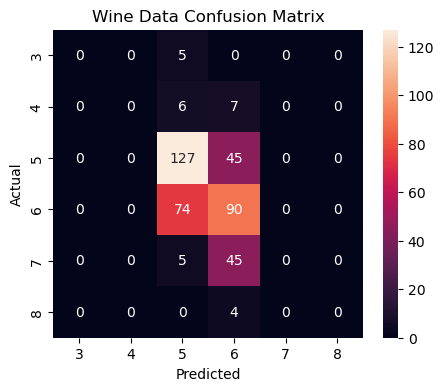

In [7]:
X = red_discretized
y = red['quality']

X_train, X_test, y_train, y_test = splitting(X=X, y=y)
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train, y_train)
predictions = decision_tree.predict(X_test)
show_results(predictions, y_test)

### NON-DISCRETIZED

Columns = ['density', 'pH', 'alcohol']
Training = [328, 1043, 318, 1208, 83]
Testing = [51, 1100, 1312, 514, 1074] 

Predictions
6    190
5    151
7     43
4      9
8      9
3      6
dtype: int64

Accuracy = 43.8725%

Classification Report
              precision    recall  f1-score   support

           3     0.0000    0.0000    0.0000         6
           4     0.0769    0.1111    0.0909         9
           5     0.4826    0.5497    0.5139       151
           6     0.4939    0.4263    0.4576       190
           7     0.2800    0.3256    0.3011        43
           8     0.0000    0.0000    0.0000         9

    accuracy                         0.4387       408
   macro avg     0.2222    0.2354    0.2273       408
weighted avg     0.4398    0.4387    0.4371       408



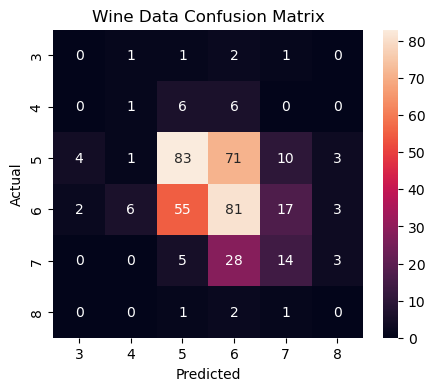

In [8]:
X = red[columns]
y = red['quality']

X_train, X_test, y_train, y_test = splitting(X=X, y=y)
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train, y_train)
predictions = decision_tree.predict(X_test)
show_results(predictions, y_test)

### ALL REMAINING ATTRIBUTES (NON-DISCRETIZED)

Columns = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'sulphates']
Training = [328, 1043, 318, 1208, 83]
Testing = [51, 1100, 1312, 514, 1074] 

Predictions
5    161
6    156
7     60
4     21
8      8
3      2
dtype: int64

Accuracy = 43.6275%

Classification Report
              precision    recall  f1-score   support

           3     0.0000    0.0000    0.0000         2
           4     0.0000    0.0000    0.0000        21
           5     0.4884    0.5217    0.5045       161
           6     0.4512    0.4744    0.4625       156
           7     0.4000    0.3333    0.3636        60
           8     0.0000    0.0000    0.0000         8

    accuracy                         0.4363       408
   macro avg     0.2233    0.2216    0.2218       408
weighted avg     0.4241    0.4363    0.4294       408



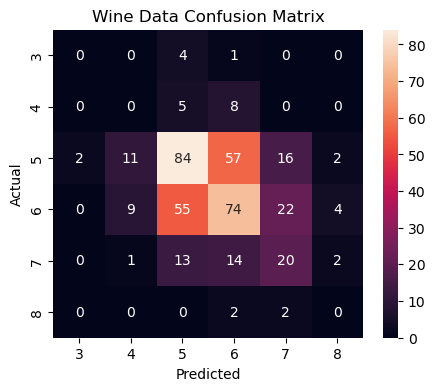

In [9]:
X = red.drop(columns + ['quality'], axis=1)
y = red['quality']

X_train, X_test, y_train, y_test = splitting(X=X, y=y)
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train, y_train)
predictions = decision_tree.predict(X_test)
show_results(predictions, y_test)